[this demo requires doom installed either from gym-pool or from [ppaquette's repo](https://github.com/ppaquette/gym-doom)]

## Basic Doom demo

* This demo solves DoomBasic env with a simple q-learning with experience replay.

# Experiment setup
* Here we basically just load the game and check that it works

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
%env THEANO_FLAGS=device=cuda,floatX=float32

env: THEANO_FLAGS=device=cuda,floatX=float32


In [2]:
import gym
import ppaquette_gym_doom
from gym.wrappers import SkipWrapper
from ppaquette_gym_doom.wrappers.action_space import ToDiscrete
from agentnet.experiments.openai_gym.wrappers import PreprocessImage
GAME_NAME = 'ppaquette/DoomDefendCenter-v0'

make_env = lambda: PreprocessImage(SkipWrapper(4)(ToDiscrete("minimal")(gym.make(GAME_NAME))),
                                   width=80,height=80,grayscale=True)

env = make_env()

Using cuDNN version 5110 on context None
Mapped name None to device cuda: Tesla K80 (0000:00:1E.0)
[2017-06-26 21:58:27,179] Making new env: ppaquette/DoomDefendCenter-v0


In [3]:
#global params.
observation_shape = env.observation_space.shape
n_actions = env.action_space.n
#number of parallel agents and batch sequence length (frames)
N_AGENTS = 1
SEQ_LENGTH = 10

0.0 False


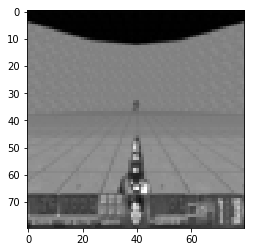

In [4]:
env.reset()
obs,r,done,_=env.step(1)
print(r, done)
plt.imshow(obs[0],cmap='gray',interpolation='none')

# Basic agent setup
Here we define a simple agent that maps game images into Qvalues using simple convolutional neural network.

![scheme](https://s18.postimg.org/gbmsq6gmx/dqn_scheme.png)

In [5]:
#setup and import theano/lasagne. Prefer GPU
%env THEANO_FLAGS=device=cuda,floatX=float32

import theano, lasagne
from lasagne.layers import *

env: THEANO_FLAGS=device=cuda,floatX=float32


In [6]:
#observation
observation_layer = InputLayer((None,)+observation_shape,)

#4-tick window over images
from agentnet.memory import WindowAugmentation, LSTMCell

prev_wnd = InputLayer((None,4)+observation_shape)
new_wnd = WindowAugmentation(observation_layer,prev_wnd)
        
#reshape to (frame, h,w). If you don't use grayscale, 4 should become 12.
wnd_reshape = reshape(new_wnd, (-1,4*observation_shape[0])+observation_shape[1:])


In [7]:
from lasagne.nonlinearities import elu,tanh,softmax
#main neural network body.
#note that we use batch normalization here which speeds up training but may
#get unstable if you use small experience replay buffer
conv0 = Conv2DLayer(wnd_reshape,32,filter_size=(8,8),stride=(4,4),name='conv0')

conv1 = Conv2DLayer(batch_norm(conv0),64,filter_size=(4,4),stride=(2,2),name='conv1')

dense = DenseLayer(batch_norm(conv1),512,name='dense',nonlinearity = lasagne.nonlinearities.tanh)        


In [8]:

#baseline for all qvalues
qvalues_layer = DenseLayer(dense,n_actions,nonlinearity=None,name='qval')
        
#sample actions proportionally to policy_layer
from agentnet.resolver import EpsilonGreedyResolver
action_layer = EpsilonGreedyResolver(qvalues_layer)


In [9]:
from agentnet.target_network import TargetNetwork
targetnet = TargetNetwork(qvalues_layer)
qvalues_old = targetnet.output_layers

##### Finally, agent
We declare that this network is and MDP agent with such and such inputs, states and outputs

In [10]:
from agentnet.agent import Agent
#all together
agent = Agent(observation_layers=observation_layer,
              policy_estimators=(qvalues_layer,qvalues_old),
              agent_states={new_wnd:prev_wnd},
              action_layers=action_layer)


In [11]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params(action_layer,trainable=True)
weights

[conv0.W,
 conv0_bn.beta,
 conv0_bn.gamma,
 conv1.W,
 conv1_bn.beta,
 conv1_bn.gamma,
 dense.W,
 dense.b,
 qval.W,
 qval.b]

# Create and manage a pool of atari sessions to play with

* To make training more stable, we shall have an entire batch of game sessions each happening independent of others
* Why several parallel agents help training: http://arxiv.org/pdf/1602.01783v1.pdf
* Alternative approach: store more sessions: https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

In [12]:
from agentnet.experiments.openai_gym.pool import EnvPool

pool = EnvPool(agent,make_env, 
               n_games=N_AGENTS,
               max_size=300) #experience replay pool holding last 1k sessions


[2017-06-26 21:58:28,080] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-26 21:58:28,089] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-26 21:58:28,096] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-26 21:58:28,104] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-26 21:58:28,111] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-26 21:58:28,119] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-26 21:58:28,127] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-26 21:58:28,135] Making new env: ppaquette/DoomDefendCenter-v0


In [13]:
%%time
#interact for 7 ticks
_,action_log,reward_log,_,_,_  = pool.interact(7)


print(action_log[:2])
print(reward_log[:2])

[[3 3 3 3 3 3 0]
 [3 3 1 3 3 3 3]]
[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]]
CPU times: user 192 ms, sys: 20 ms, total: 212 ms
Wall time: 620 ms


In [14]:
#load first sessions (this function calls interact and remembers sessions)
pool.update(SEQ_LENGTH)

# Q-learning
* An agent has a method that produces symbolic environment interaction sessions
* Such sessions are in sequences of observations, agent memory, actions, q-values,etc
  * one has to pre-define maximum session length.

* SessionPool also stores rewards (Q-learning objective)

In [15]:
#get agent's Qvalues obtained via experience replay
replay = pool.experience_replay.sample_session_batch(100,replace=True)

_,_,_,_,(qvalues_seq,old_qvalues_seq) = agent.get_sessions(
    replay,
    session_length=SEQ_LENGTH,
    experience_replay=True,
)



In [16]:
#get reference Qvalues according to Qlearning algorithm
from agentnet.learning import qlearning

#loss for Qlearning = (Q(s,a) - (r+gamma*Q(s',a_max)))^2
elwise_mse_loss = qlearning.get_elementwise_objective(qvalues_seq,
                                                      replay.actions[0],
                                                      replay.rewards,
                                                      replay.is_alive,
                                                      qvalues_target=old_qvalues_seq,
                                                      gamma_or_gammas=0.99)

#compute mean over "alive" fragments
loss = elwise_mse_loss.sum() / replay.is_alive.sum()

In [17]:
# Compute weight updates
updates = lasagne.updates.adam(loss,weights)

#compile train function
import theano
train_step = theano.function([],loss,updates=updates)

# Demo run

In [18]:
action_layer.epsilon.set_value(0)
untrained_reward = np.mean(pool.evaluate(save_path="./records",record_video=True,n_games=10))

[2017-06-26 21:59:01,055] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-26 21:59:01,064] Clearing 12 monitor files from previous run (because force=True was provided)
[2017-06-26 21:59:01,314] Starting new video recorder writing to /home/ubuntu/records/openaigym.video.0.15673.video000000.mp4


Episode finished after 54 timesteps with reward=-1.0


[2017-06-26 21:59:02,933] Starting new video recorder writing to /home/ubuntu/records/openaigym.video.0.15673.video000001.mp4


Episode finished after 72 timesteps with reward=0.0
Episode finished after 53 timesteps with reward=-1.0
Episode finished after 63 timesteps with reward=0.0
Episode finished after 48 timesteps with reward=-1.0
Episode finished after 53 timesteps with reward=-1.0
Episode finished after 84 timesteps with reward=1.0


[2017-06-26 21:59:09,741] Starting new video recorder writing to /home/ubuntu/records/openaigym.video.0.15673.video000008.mp4


Episode finished after 54 timesteps with reward=-1.0
Episode finished after 55 timesteps with reward=-1.0


[2017-06-26 21:59:12,162] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')


Episode finished after 60 timesteps with reward=-1.0


In [19]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./records/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./records/"+video_names[-1])) #this may or may not be _last_ video. Try other indices

# Training loop

In [20]:
#starting epoch
epoch_counter = 1

#full game rewards
rewards = {0:[untrained_reward]}


In [21]:
from tqdm import trange
#the loop may take eons to finish.
#consider interrupting early.
for i in trange(2000):    
    
    
    #train
    pool.update(SEQ_LENGTH, append=True)
    
    loss = train_step()
    
    targetnet.load_weights(0.01)
    
    ##update resolver's epsilon (chance of random action instead of optimal one)
    current_epsilon = 0.05 + 0.95*np.exp(-epoch_counter/200.)
    action_layer.epsilon.set_value(np.float32(current_epsilon))
    
    if epoch_counter%10==0:
        #average reward per game tick in current experience replay pool
        pool_mean_reward = pool.experience_replay.rewards.get_value().mean()
        print("iter=%i\tepsilon=%.3f\treward/step=%.5f"%(epoch_counter,
                                                         current_epsilon,
                                                         pool_mean_reward))
        
    ##record current learning progress and show learning curves
    if epoch_counter%50 ==0:
        rewards[epoch_counter] = pool.evaluate(5, record_video=False)
    
    epoch_counter  +=1

    
# Time to drink some coffee!

  0%|          | 10/2000 [00:10<34:40,  1.05s/it]

iter=10	epsilon=0.954	reward/step=0.02500


  1%|          | 20/2000 [00:20<34:10,  1.04s/it]

iter=20	epsilon=0.910	reward/step=-0.01250


  2%|▏         | 30/2000 [00:30<33:49,  1.03s/it]

iter=30	epsilon=0.868	reward/step=0.01250


  2%|▏         | 40/2000 [00:40<33:33,  1.03s/it]

iter=40	epsilon=0.828	reward/step=-0.02500


  2%|▏         | 49/2000 [00:50<33:09,  1.02s/it][2017-06-26 22:00:03,333] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-26 22:00:03,338] Clearing 8 monitor files from previous run (because force=True was provided)


iter=50	epsilon=0.790	reward/step=-0.02500
Episode finished after 74 timesteps with reward=1.0
Episode finished after 54 timesteps with reward=1.0
Episode finished after 65 timesteps with reward=0.0
Episode finished after 76 timesteps with reward=0.0


[2017-06-26 22:00:08,148] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
  2%|▎         | 50/2000 [00:55<1:20:27,  2.48s/it]

Episode finished after 72 timesteps with reward=0.0


  3%|▎         | 60/2000 [01:06<34:52,  1.08s/it]  

iter=60	epsilon=0.754	reward/step=0.01250


  4%|▎         | 70/2000 [01:16<33:04,  1.03s/it]

iter=70	epsilon=0.719	reward/step=0.01250


  4%|▍         | 80/2000 [01:26<32:46,  1.02s/it]

iter=80	epsilon=0.687	reward/step=-0.01250


  4%|▍         | 90/2000 [01:36<32:37,  1.02s/it]

iter=90	epsilon=0.656	reward/step=-0.01250


  5%|▍         | 99/2000 [01:45<32:11,  1.02s/it][2017-06-26 22:00:59,046] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-26 22:00:59,051] Clearing 2 monitor files from previous run (because force=True was provided)


iter=100	epsilon=0.626	reward/step=0.02500
Episode finished after 58 timesteps with reward=1.0
Episode finished after 73 timesteps with reward=0.0
Episode finished after 58 timesteps with reward=0.0
Episode finished after 56 timesteps with reward=0.0


[2017-06-26 22:01:03,315] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
  5%|▌         | 100/2000 [01:51<1:13:34,  2.32s/it]

Episode finished after 56 timesteps with reward=0.0


  6%|▌         | 110/2000 [02:01<34:10,  1.08s/it]  

iter=110	epsilon=0.598	reward/step=0.01250


  6%|▌         | 120/2000 [02:11<31:55,  1.02s/it]

iter=120	epsilon=0.571	reward/step=-0.01250


  6%|▋         | 130/2000 [02:21<31:54,  1.02s/it]

iter=130	epsilon=0.546	reward/step=-0.01250


  7%|▋         | 140/2000 [02:31<31:37,  1.02s/it]

iter=140	epsilon=0.522	reward/step=-0.02500


  7%|▋         | 149/2000 [02:40<31:20,  1.02s/it][2017-06-26 22:01:54,261] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-26 22:01:54,266] Clearing 2 monitor files from previous run (because force=True was provided)


iter=150	epsilon=0.499	reward/step=0.02500
Episode finished after 65 timesteps with reward=0.0
Episode finished after 80 timesteps with reward=3.0
Episode finished after 48 timesteps with reward=0.0
Episode finished after 64 timesteps with reward=-1.0


[2017-06-26 22:01:59,042] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
  8%|▊         | 150/2000 [02:46<1:16:08,  2.47s/it]

Episode finished after 84 timesteps with reward=1.0


  8%|▊         | 160/2000 [02:56<32:30,  1.06s/it]  

iter=160	epsilon=0.477	reward/step=-0.02500


  8%|▊         | 170/2000 [03:07<31:23,  1.03s/it]

iter=170	epsilon=0.456	reward/step=0.00000


  9%|▉         | 180/2000 [03:17<31:24,  1.04s/it]

iter=180	epsilon=0.436	reward/step=0.01250


 10%|▉         | 190/2000 [03:27<31:52,  1.06s/it]

iter=190	epsilon=0.417	reward/step=0.02500


 10%|▉         | 199/2000 [03:36<30:41,  1.02s/it][2017-06-26 22:02:50,024] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-26 22:02:50,028] Clearing 2 monitor files from previous run (because force=True was provided)


iter=200	epsilon=0.399	reward/step=0.00000
Episode finished after 80 timesteps with reward=2.0
Episode finished after 74 timesteps with reward=1.0
Episode finished after 63 timesteps with reward=0.0
Episode finished after 57 timesteps with reward=-1.0


[2017-06-26 22:02:55,044] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 10%|█         | 200/2000 [03:42<1:16:23,  2.55s/it]

Episode finished after 82 timesteps with reward=2.0


 10%|█         | 210/2000 [03:53<32:07,  1.08s/it]  

iter=210	epsilon=0.382	reward/step=0.01250


 11%|█         | 220/2000 [04:03<30:38,  1.03s/it]

iter=220	epsilon=0.366	reward/step=0.01250


 12%|█▏        | 230/2000 [04:13<30:36,  1.04s/it]

iter=230	epsilon=0.351	reward/step=-0.01250


 12%|█▏        | 240/2000 [04:23<30:01,  1.02s/it]

iter=240	epsilon=0.336	reward/step=-0.01250


 12%|█▏        | 249/2000 [04:32<29:22,  1.01s/it][2017-06-26 22:03:45,902] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-26 22:03:45,907] Clearing 2 monitor files from previous run (because force=True was provided)


iter=250	epsilon=0.322	reward/step=0.02500
Episode finished after 82 timesteps with reward=1.0
Episode finished after 79 timesteps with reward=2.0
Episode finished after 96 timesteps with reward=4.0
Episode finished after 98 timesteps with reward=2.0


[2017-06-26 22:03:52,178] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 12%|█▎        | 250/2000 [04:39<1:25:02,  2.92s/it]

Episode finished after 96 timesteps with reward=4.0


 13%|█▎        | 260/2000 [04:50<31:21,  1.08s/it]  

iter=260	epsilon=0.309	reward/step=0.02500


 14%|█▎        | 270/2000 [05:00<29:30,  1.02s/it]

iter=270	epsilon=0.296	reward/step=0.01250


 14%|█▍        | 280/2000 [05:10<30:09,  1.05s/it]

iter=280	epsilon=0.284	reward/step=0.03750


 14%|█▍        | 290/2000 [05:20<29:17,  1.03s/it]

iter=290	epsilon=0.273	reward/step=0.01250


 15%|█▍        | 299/2000 [05:29<28:46,  1.01s/it][2017-06-26 22:04:43,101] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-26 22:04:43,108] Clearing 2 monitor files from previous run (because force=True was provided)


iter=300	epsilon=0.262	reward/step=0.03750
Episode finished after 74 timesteps with reward=4.0
Episode finished after 91 timesteps with reward=4.0
Episode finished after 88 timesteps with reward=3.0
Episode finished after 105 timesteps with reward=5.0


[2017-06-26 22:04:49,206] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 15%|█▌        | 300/2000 [05:36<1:21:13,  2.87s/it]

Episode finished after 82 timesteps with reward=5.0


 16%|█▌        | 310/2000 [05:47<30:31,  1.08s/it]  

iter=310	epsilon=0.252	reward/step=0.01250


 16%|█▌        | 320/2000 [05:57<29:11,  1.04s/it]

iter=320	epsilon=0.242	reward/step=0.02500


 16%|█▋        | 330/2000 [06:07<28:42,  1.03s/it]

iter=330	epsilon=0.232	reward/step=0.01250


 17%|█▋        | 340/2000 [06:17<28:17,  1.02s/it]

iter=340	epsilon=0.224	reward/step=0.00000


 17%|█▋        | 349/2000 [06:26<27:58,  1.02s/it][2017-06-26 22:05:40,139] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-26 22:05:40,145] Clearing 2 monitor files from previous run (because force=True was provided)


iter=350	epsilon=0.215	reward/step=0.06250
Episode finished after 162 timesteps with reward=7.0
Episode finished after 85 timesteps with reward=3.0
Episode finished after 111 timesteps with reward=5.0
Episode finished after 98 timesteps with reward=4.0


[2017-06-26 22:05:47,281] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 18%|█▊        | 350/2000 [06:35<1:27:33,  3.18s/it]

Episode finished after 63 timesteps with reward=0.0


 18%|█▊        | 360/2000 [06:45<29:52,  1.09s/it]  

iter=360	epsilon=0.207	reward/step=-0.01250


 18%|█▊        | 370/2000 [06:55<27:53,  1.03s/it]

iter=370	epsilon=0.199	reward/step=0.02500


 19%|█▉        | 380/2000 [07:05<27:52,  1.03s/it]

iter=380	epsilon=0.192	reward/step=0.01250


 20%|█▉        | 390/2000 [07:15<27:35,  1.03s/it]

iter=390	epsilon=0.185	reward/step=0.02500


 20%|█▉        | 399/2000 [07:24<27:03,  1.01s/it][2017-06-26 22:06:38,102] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-26 22:06:38,107] Clearing 2 monitor files from previous run (because force=True was provided)


iter=400	epsilon=0.179	reward/step=0.00000
Episode finished after 86 timesteps with reward=2.0
Episode finished after 141 timesteps with reward=7.0
Episode finished after 103 timesteps with reward=5.0
Episode finished after 58 timesteps with reward=2.0


[2017-06-26 22:06:44,830] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 20%|██        | 400/2000 [07:32<1:21:22,  3.05s/it]

Episode finished after 97 timesteps with reward=4.0


 20%|██        | 410/2000 [07:42<28:43,  1.08s/it]  

iter=410	epsilon=0.172	reward/step=0.00000


 21%|██        | 420/2000 [07:53<27:10,  1.03s/it]

iter=420	epsilon=0.166	reward/step=0.02500


 22%|██▏       | 430/2000 [08:03<26:59,  1.03s/it]

iter=430	epsilon=0.161	reward/step=0.01250


 22%|██▏       | 440/2000 [08:13<26:49,  1.03s/it]

iter=440	epsilon=0.155	reward/step=0.02500


 22%|██▏       | 449/2000 [08:22<26:30,  1.03s/it][2017-06-26 22:07:35,904] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-26 22:07:35,910] Clearing 2 monitor files from previous run (because force=True was provided)


iter=450	epsilon=0.150	reward/step=0.05000
Episode finished after 78 timesteps with reward=2.0
Episode finished after 66 timesteps with reward=2.0
Episode finished after 87 timesteps with reward=2.0
Episode finished after 86 timesteps with reward=3.0


[2017-06-26 22:07:41,194] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 22%|██▎       | 450/2000 [08:28<1:07:52,  2.63s/it]

Episode finished after 63 timesteps with reward=1.0


 23%|██▎       | 460/2000 [08:39<27:29,  1.07s/it]  

iter=460	epsilon=0.145	reward/step=0.02500


 24%|██▎       | 470/2000 [08:49<26:24,  1.04s/it]

iter=470	epsilon=0.141	reward/step=0.00000


 24%|██▍       | 480/2000 [08:59<25:54,  1.02s/it]

iter=480	epsilon=0.136	reward/step=0.00000


 24%|██▍       | 490/2000 [09:09<25:50,  1.03s/it]

iter=490	epsilon=0.132	reward/step=0.00000


 25%|██▍       | 499/2000 [09:18<25:27,  1.02s/it][2017-06-26 22:08:32,047] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-26 22:08:32,053] Clearing 2 monitor files from previous run (because force=True was provided)


iter=500	epsilon=0.128	reward/step=0.03750
Episode finished after 91 timesteps with reward=3.0
Episode finished after 100 timesteps with reward=4.0
Episode finished after 98 timesteps with reward=4.0
Episode finished after 109 timesteps with reward=5.0


[2017-06-26 22:08:38,727] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 25%|██▌       | 500/2000 [09:26<1:15:58,  3.04s/it]

Episode finished after 83 timesteps with reward=3.0


 26%|██▌       | 510/2000 [09:36<27:02,  1.09s/it]  

iter=510	epsilon=0.124	reward/step=0.06250


 26%|██▌       | 520/2000 [09:46<25:28,  1.03s/it]

iter=520	epsilon=0.121	reward/step=0.02500


 26%|██▋       | 530/2000 [09:56<24:57,  1.02s/it]

iter=530	epsilon=0.117	reward/step=-0.01250


 27%|██▋       | 540/2000 [10:07<24:59,  1.03s/it]

iter=540	epsilon=0.114	reward/step=0.01250


 27%|██▋       | 549/2000 [10:16<24:39,  1.02s/it][2017-06-26 22:09:29,515] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-26 22:09:29,521] Clearing 2 monitor files from previous run (because force=True was provided)


iter=550	epsilon=0.111	reward/step=0.08750
Episode finished after 76 timesteps with reward=2.0
Episode finished after 104 timesteps with reward=4.0
Episode finished after 110 timesteps with reward=5.0
Episode finished after 83 timesteps with reward=2.0


[2017-06-26 22:09:35,802] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 28%|██▊       | 550/2000 [10:23<1:10:41,  2.93s/it]

Episode finished after 82 timesteps with reward=2.0


 28%|██▊       | 560/2000 [10:33<26:00,  1.08s/it]  

iter=560	epsilon=0.108	reward/step=0.01250


 28%|██▊       | 570/2000 [10:43<24:41,  1.04s/it]

iter=570	epsilon=0.105	reward/step=0.05000


 29%|██▉       | 580/2000 [10:54<24:27,  1.03s/it]

iter=580	epsilon=0.102	reward/step=0.03750


 30%|██▉       | 590/2000 [11:04<24:05,  1.02s/it]

iter=590	epsilon=0.100	reward/step=0.02500


 30%|██▉       | 599/2000 [11:13<23:48,  1.02s/it][2017-06-26 22:10:26,759] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-26 22:10:26,764] Clearing 2 monitor files from previous run (because force=True was provided)


iter=600	epsilon=0.097	reward/step=-0.01250
Episode finished after 56 timesteps with reward=2.0
Episode finished after 53 timesteps with reward=1.0
Episode finished after 73 timesteps with reward=0.0
Episode finished after 52 timesteps with reward=0.0


[2017-06-26 22:10:30,957] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 30%|███       | 600/2000 [11:18<53:39,  2.30s/it]

Episode finished after 65 timesteps with reward=1.0


 30%|███       | 610/2000 [11:28<24:42,  1.07s/it]

iter=610	epsilon=0.095	reward/step=0.01250


 31%|███       | 620/2000 [11:39<23:55,  1.04s/it]

iter=620	epsilon=0.093	reward/step=0.01250


 32%|███▏      | 630/2000 [11:49<23:21,  1.02s/it]

iter=630	epsilon=0.091	reward/step=-0.02500


 32%|███▏      | 640/2000 [11:59<23:19,  1.03s/it]

iter=640	epsilon=0.089	reward/step=0.02500


 32%|███▏      | 649/2000 [12:08<22:53,  1.02s/it][2017-06-26 22:11:21,707] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-26 22:11:21,712] Clearing 2 monitor files from previous run (because force=True was provided)


iter=650	epsilon=0.087	reward/step=0.03750
Episode finished after 50 timesteps with reward=0.0
Episode finished after 54 timesteps with reward=0.0
Episode finished after 84 timesteps with reward=1.0
Episode finished after 80 timesteps with reward=1.0


[2017-06-26 22:11:26,752] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 32%|███▎      | 650/2000 [12:14<57:27,  2.55s/it]

Episode finished after 94 timesteps with reward=1.0


 33%|███▎      | 660/2000 [12:24<24:04,  1.08s/it]

iter=660	epsilon=0.085	reward/step=0.05000


 34%|███▎      | 670/2000 [12:34<23:05,  1.04s/it]

iter=670	epsilon=0.083	reward/step=0.02500


 34%|███▍      | 680/2000 [12:45<22:39,  1.03s/it]

iter=680	epsilon=0.082	reward/step=-0.01250


 34%|███▍      | 690/2000 [12:55<22:24,  1.03s/it]

iter=690	epsilon=0.080	reward/step=0.01250


 35%|███▍      | 699/2000 [13:04<21:45,  1.00s/it][2017-06-26 22:12:17,550] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-26 22:12:17,556] Clearing 2 monitor files from previous run (because force=True was provided)


iter=700	epsilon=0.079	reward/step=0.02500
Episode finished after 80 timesteps with reward=2.0
Episode finished after 54 timesteps with reward=0.0
Episode finished after 60 timesteps with reward=0.0
Episode finished after 44 timesteps with reward=0.0


[2017-06-26 22:12:21,726] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 35%|███▌      | 700/2000 [13:09<49:23,  2.28s/it]

Episode finished after 60 timesteps with reward=2.0


 36%|███▌      | 710/2000 [13:19<22:56,  1.07s/it]

iter=710	epsilon=0.077	reward/step=0.03750


 36%|███▌      | 720/2000 [13:29<22:02,  1.03s/it]

iter=720	epsilon=0.076	reward/step=0.05000


 36%|███▋      | 730/2000 [13:40<21:47,  1.03s/it]

iter=730	epsilon=0.075	reward/step=0.05000


 37%|███▋      | 740/2000 [13:50<21:28,  1.02s/it]

iter=740	epsilon=0.073	reward/step=-0.01250


 37%|███▋      | 749/2000 [13:59<21:12,  1.02s/it][2017-06-26 22:13:12,624] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-26 22:13:12,629] Clearing 2 monitor files from previous run (because force=True was provided)


iter=750	epsilon=0.072	reward/step=0.06250
Episode finished after 95 timesteps with reward=3.0
Episode finished after 98 timesteps with reward=5.0
Episode finished after 101 timesteps with reward=5.0
Episode finished after 102 timesteps with reward=6.0


[2017-06-26 22:13:18,815] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 38%|███▊      | 750/2000 [14:06<1:00:18,  2.90s/it]

Episode finished after 52 timesteps with reward=2.0


 38%|███▊      | 760/2000 [14:16<22:44,  1.10s/it]  

iter=760	epsilon=0.071	reward/step=0.03750


 38%|███▊      | 770/2000 [14:27<21:17,  1.04s/it]

iter=770	epsilon=0.070	reward/step=0.02500


 39%|███▉      | 780/2000 [14:37<21:03,  1.04s/it]

iter=780	epsilon=0.069	reward/step=0.07500


 40%|███▉      | 790/2000 [14:47<20:55,  1.04s/it]

iter=790	epsilon=0.068	reward/step=0.01250


 40%|███▉      | 799/2000 [14:56<20:13,  1.01s/it][2017-06-26 22:14:09,928] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-26 22:14:09,933] Clearing 2 monitor files from previous run (because force=True was provided)


iter=800	epsilon=0.067	reward/step=0.00000
Episode finished after 89 timesteps with reward=2.0
Episode finished after 78 timesteps with reward=2.0
Episode finished after 79 timesteps with reward=2.0
Episode finished after 80 timesteps with reward=2.0


[2017-06-26 22:14:15,577] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 40%|████      | 800/2000 [15:03<54:27,  2.72s/it]

Episode finished after 78 timesteps with reward=1.0


 40%|████      | 810/2000 [15:13<21:31,  1.08s/it]

iter=810	epsilon=0.067	reward/step=0.00000


 41%|████      | 820/2000 [15:23<20:14,  1.03s/it]

iter=820	epsilon=0.066	reward/step=0.00000


 42%|████▏     | 830/2000 [15:34<20:06,  1.03s/it]

iter=830	epsilon=0.065	reward/step=0.01250


 42%|████▏     | 840/2000 [15:44<19:49,  1.03s/it]

iter=840	epsilon=0.064	reward/step=0.01250


 42%|████▏     | 849/2000 [15:53<19:34,  1.02s/it][2017-06-26 22:15:06,612] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-26 22:15:06,617] Clearing 2 monitor files from previous run (because force=True was provided)


iter=850	epsilon=0.064	reward/step=-0.01250
Episode finished after 120 timesteps with reward=5.0
Episode finished after 99 timesteps with reward=2.0
Episode finished after 102 timesteps with reward=4.0
Episode finished after 83 timesteps with reward=3.0


[2017-06-26 22:15:13,339] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 42%|████▎     | 850/2000 [16:01<58:26,  3.05s/it]

Episode finished after 85 timesteps with reward=3.0


 43%|████▎     | 860/2000 [16:11<20:30,  1.08s/it]

iter=860	epsilon=0.063	reward/step=-0.02500


 44%|████▎     | 870/2000 [16:21<19:22,  1.03s/it]

iter=870	epsilon=0.062	reward/step=0.02500


 44%|████▍     | 880/2000 [16:31<19:12,  1.03s/it]

iter=880	epsilon=0.062	reward/step=0.01250


 44%|████▍     | 890/2000 [16:41<19:02,  1.03s/it]

iter=890	epsilon=0.061	reward/step=0.03750


 45%|████▍     | 899/2000 [16:50<18:32,  1.01s/it][2017-06-26 22:16:04,190] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-26 22:16:04,196] Clearing 2 monitor files from previous run (because force=True was provided)


iter=900	epsilon=0.061	reward/step=0.00000
Episode finished after 55 timesteps with reward=-1.0
Episode finished after 53 timesteps with reward=-1.0
Episode finished after 76 timesteps with reward=0.0
Episode finished after 75 timesteps with reward=-1.0


[2017-06-26 22:16:08,508] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 45%|████▌     | 900/2000 [16:56<42:39,  2.33s/it]

Episode finished after 48 timesteps with reward=-1.0


 46%|████▌     | 910/2000 [17:06<19:14,  1.06s/it]

iter=910	epsilon=0.060	reward/step=-0.01250


 46%|████▌     | 920/2000 [17:16<18:30,  1.03s/it]

iter=920	epsilon=0.060	reward/step=-0.02500


 46%|████▋     | 930/2000 [17:26<18:07,  1.02s/it]

iter=930	epsilon=0.059	reward/step=0.00000


 47%|████▋     | 940/2000 [17:36<18:03,  1.02s/it]

iter=940	epsilon=0.059	reward/step=0.00000


 47%|████▋     | 949/2000 [17:45<17:50,  1.02s/it][2017-06-26 22:16:59,036] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-26 22:16:59,042] Clearing 2 monitor files from previous run (because force=True was provided)


iter=950	epsilon=0.058	reward/step=0.05000
Episode finished after 119 timesteps with reward=5.0
Episode finished after 181 timesteps with reward=7.0
Episode finished after 102 timesteps with reward=5.0
Episode finished after 86 timesteps with reward=4.0


[2017-06-26 22:17:07,081] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 48%|████▊     | 950/2000 [17:54<1:00:22,  3.45s/it]

Episode finished after 94 timesteps with reward=5.0


 48%|████▊     | 960/2000 [18:05<19:05,  1.10s/it]  

iter=960	epsilon=0.058	reward/step=0.07500


 48%|████▊     | 970/2000 [18:15<17:43,  1.03s/it]

iter=970	epsilon=0.057	reward/step=0.02500


 49%|████▉     | 980/2000 [18:25<17:24,  1.02s/it]

iter=980	epsilon=0.057	reward/step=0.02500


 50%|████▉     | 990/2000 [18:35<17:12,  1.02s/it]

iter=990	epsilon=0.057	reward/step=0.00000


 50%|████▉     | 999/2000 [18:44<16:55,  1.01s/it][2017-06-26 22:17:57,958] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-26 22:17:57,963] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1000	epsilon=0.056	reward/step=0.02500
Episode finished after 41 timesteps with reward=-1.0
Episode finished after 64 timesteps with reward=0.0
Episode finished after 71 timesteps with reward=1.0
Episode finished after 46 timesteps with reward=-1.0


[2017-06-26 22:18:01,825] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 50%|█████     | 1000/2000 [18:49<36:33,  2.19s/it]

Episode finished after 47 timesteps with reward=-1.0


 50%|█████     | 1010/2000 [18:59<17:34,  1.07s/it]

iter=1010	epsilon=0.056	reward/step=0.06250


 51%|█████     | 1020/2000 [19:09<16:42,  1.02s/it]

iter=1020	epsilon=0.056	reward/step=0.01250


 52%|█████▏    | 1030/2000 [19:20<16:39,  1.03s/it]

iter=1030	epsilon=0.056	reward/step=0.02500


 52%|█████▏    | 1040/2000 [19:30<16:36,  1.04s/it]

iter=1040	epsilon=0.055	reward/step=0.01250


 52%|█████▏    | 1049/2000 [19:39<16:12,  1.02s/it][2017-06-26 22:18:52,668] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-26 22:18:52,673] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1050	epsilon=0.055	reward/step=0.03750
Episode finished after 78 timesteps with reward=2.0
Episode finished after 86 timesteps with reward=1.0
Episode finished after 157 timesteps with reward=8.0
Episode finished after 98 timesteps with reward=3.0


[2017-06-26 22:18:59,662] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 52%|█████▎    | 1050/2000 [19:47<49:38,  3.14s/it]

Episode finished after 90 timesteps with reward=2.0


 53%|█████▎    | 1060/2000 [19:57<16:59,  1.08s/it]

iter=1060	epsilon=0.055	reward/step=0.03750


 54%|█████▎    | 1070/2000 [20:07<16:04,  1.04s/it]

iter=1070	epsilon=0.055	reward/step=0.03750


 54%|█████▍    | 1080/2000 [20:18<16:00,  1.04s/it]

iter=1080	epsilon=0.054	reward/step=0.01250


 55%|█████▍    | 1090/2000 [20:28<15:40,  1.03s/it]

iter=1090	epsilon=0.054	reward/step=0.00000


 55%|█████▍    | 1099/2000 [20:37<15:17,  1.02s/it][2017-06-26 22:19:50,616] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-26 22:19:50,620] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1100	epsilon=0.054	reward/step=0.05000
Episode finished after 73 timesteps with reward=2.0
Episode finished after 51 timesteps with reward=1.0
Episode finished after 54 timesteps with reward=1.0
Episode finished after 51 timesteps with reward=3.0


[2017-06-26 22:19:54,663] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 55%|█████▌    | 1100/2000 [20:42<33:47,  2.25s/it]

Episode finished after 56 timesteps with reward=1.0


 56%|█████▌    | 1110/2000 [20:52<15:46,  1.06s/it]

iter=1110	epsilon=0.054	reward/step=0.00000


 56%|█████▌    | 1120/2000 [21:02<15:11,  1.04s/it]

iter=1120	epsilon=0.054	reward/step=0.01250


 56%|█████▋    | 1130/2000 [21:13<15:04,  1.04s/it]

iter=1130	epsilon=0.053	reward/step=0.03750


 57%|█████▋    | 1140/2000 [21:23<14:48,  1.03s/it]

iter=1140	epsilon=0.053	reward/step=0.02500


 57%|█████▋    | 1149/2000 [21:32<14:32,  1.03s/it][2017-06-26 22:20:45,732] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-26 22:20:45,736] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1150	epsilon=0.053	reward/step=0.00000
Episode finished after 152 timesteps with reward=6.0
Episode finished after 95 timesteps with reward=5.0
Episode finished after 75 timesteps with reward=2.0
Episode finished after 82 timesteps with reward=3.0


[2017-06-26 22:20:52,547] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 57%|█████▊    | 1150/2000 [21:40<43:41,  3.08s/it]

Episode finished after 90 timesteps with reward=4.0


 58%|█████▊    | 1160/2000 [21:50<15:15,  1.09s/it]

iter=1160	epsilon=0.053	reward/step=0.07500


 58%|█████▊    | 1170/2000 [22:00<14:19,  1.04s/it]

iter=1170	epsilon=0.053	reward/step=0.03750


 59%|█████▉    | 1180/2000 [22:10<13:56,  1.02s/it]

iter=1180	epsilon=0.053	reward/step=0.00000


 60%|█████▉    | 1190/2000 [22:20<13:54,  1.03s/it]

iter=1190	epsilon=0.052	reward/step=0.01250


 60%|█████▉    | 1199/2000 [22:30<13:30,  1.01s/it][2017-06-26 22:21:43,361] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-26 22:21:43,367] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1200	epsilon=0.052	reward/step=0.00000
Episode finished after 47 timesteps with reward=0.0
Episode finished after 63 timesteps with reward=0.0
Episode finished after 59 timesteps with reward=0.0
Episode finished after 40 timesteps with reward=0.0


[2017-06-26 22:21:47,162] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 60%|██████    | 1200/2000 [22:34<28:56,  2.17s/it]

Episode finished after 60 timesteps with reward=0.0


 60%|██████    | 1210/2000 [22:45<13:58,  1.06s/it]

iter=1210	epsilon=0.052	reward/step=-0.01250


 61%|██████    | 1220/2000 [22:55<13:18,  1.02s/it]

iter=1220	epsilon=0.052	reward/step=0.01250


 62%|██████▏   | 1230/2000 [23:05<13:08,  1.02s/it]

iter=1230	epsilon=0.052	reward/step=-0.01250


 62%|██████▏   | 1240/2000 [23:15<13:04,  1.03s/it]

iter=1240	epsilon=0.052	reward/step=0.03750


 62%|██████▏   | 1249/2000 [23:24<12:43,  1.02s/it][2017-06-26 22:22:37,868] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-26 22:22:37,873] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1250	epsilon=0.052	reward/step=0.06250
Episode finished after 108 timesteps with reward=6.0
Episode finished after 135 timesteps with reward=8.0
Episode finished after 95 timesteps with reward=4.0
Episode finished after 148 timesteps with reward=8.0


[2017-06-26 22:22:46,146] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 62%|██████▎   | 1250/2000 [23:33<43:58,  3.52s/it]

Episode finished after 115 timesteps with reward=7.0


 63%|██████▎   | 1260/2000 [23:44<13:39,  1.11s/it]

iter=1260	epsilon=0.052	reward/step=0.01250


 64%|██████▎   | 1270/2000 [23:54<12:24,  1.02s/it]

iter=1270	epsilon=0.052	reward/step=-0.01250


 64%|██████▍   | 1280/2000 [24:04<12:26,  1.04s/it]

iter=1280	epsilon=0.052	reward/step=0.06250


 64%|██████▍   | 1290/2000 [24:14<12:14,  1.03s/it]

iter=1290	epsilon=0.052	reward/step=0.06250


 65%|██████▍   | 1299/2000 [24:23<11:49,  1.01s/it][2017-06-26 22:23:37,086] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-26 22:23:37,091] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1300	epsilon=0.051	reward/step=0.02500
Episode finished after 58 timesteps with reward=0.0
Episode finished after 78 timesteps with reward=1.0
Episode finished after 62 timesteps with reward=-1.0
Episode finished after 81 timesteps with reward=0.0


[2017-06-26 22:23:41,862] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 65%|██████▌   | 1300/2000 [24:29<28:45,  2.47s/it]

Episode finished after 64 timesteps with reward=0.0


 66%|██████▌   | 1310/2000 [24:39<12:14,  1.06s/it]

iter=1310	epsilon=0.051	reward/step=0.01250


 66%|██████▌   | 1320/2000 [24:49<11:44,  1.04s/it]

iter=1320	epsilon=0.051	reward/step=0.02500


 66%|██████▋   | 1330/2000 [25:00<11:29,  1.03s/it]

iter=1330	epsilon=0.051	reward/step=0.03750


 67%|██████▋   | 1340/2000 [25:10<11:27,  1.04s/it]

iter=1340	epsilon=0.051	reward/step=0.07500


 67%|██████▋   | 1349/2000 [25:19<11:07,  1.03s/it][2017-06-26 22:24:32,830] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-26 22:24:32,836] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1350	epsilon=0.051	reward/step=0.02500
Episode finished after 82 timesteps with reward=4.0
Episode finished after 127 timesteps with reward=7.0
Episode finished after 99 timesteps with reward=4.0
Episode finished after 99 timesteps with reward=7.0


[2017-06-26 22:24:39,471] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 68%|██████▊   | 1350/2000 [25:27<32:51,  3.03s/it]

Episode finished after 74 timesteps with reward=3.0


 68%|██████▊   | 1360/2000 [25:37<11:35,  1.09s/it]

iter=1360	epsilon=0.051	reward/step=0.03750


 68%|██████▊   | 1370/2000 [25:47<10:41,  1.02s/it]

iter=1370	epsilon=0.051	reward/step=0.00000


 69%|██████▉   | 1380/2000 [25:57<10:38,  1.03s/it]

iter=1380	epsilon=0.051	reward/step=-0.01250


 70%|██████▉   | 1390/2000 [26:07<10:29,  1.03s/it]

iter=1390	epsilon=0.051	reward/step=0.00000


 70%|██████▉   | 1399/2000 [26:16<10:09,  1.01s/it][2017-06-26 22:25:30,174] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-26 22:25:30,180] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1400	epsilon=0.051	reward/step=0.05000
Episode finished after 91 timesteps with reward=2.0
Episode finished after 91 timesteps with reward=1.0
Episode finished after 80 timesteps with reward=2.0
Episode finished after 204 timesteps with reward=10.0


[2017-06-26 22:25:38,015] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 70%|███████   | 1400/2000 [26:25<33:50,  3.38s/it]

Episode finished after 106 timesteps with reward=5.0


 70%|███████   | 1410/2000 [26:35<10:45,  1.09s/it]

iter=1410	epsilon=0.051	reward/step=0.00000


 71%|███████   | 1420/2000 [26:46<09:53,  1.02s/it]

iter=1420	epsilon=0.051	reward/step=0.00000


 72%|███████▏  | 1430/2000 [26:56<09:54,  1.04s/it]

iter=1430	epsilon=0.051	reward/step=0.01250


 72%|███████▏  | 1440/2000 [27:06<09:37,  1.03s/it]

iter=1440	epsilon=0.051	reward/step=0.06250


 72%|███████▏  | 1449/2000 [27:15<09:22,  1.02s/it][2017-06-26 22:26:28,836] Making new env: ppaquette/DoomDefendCenter-v0
[2017-06-26 22:26:28,841] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1450	epsilon=0.051	reward/step=0.06250
Episode finished after 65 timesteps with reward=3.0
Episode finished after 99 timesteps with reward=3.0
Episode finished after 49 timesteps with reward=1.0
Episode finished after 90 timesteps with reward=3.0


[2017-06-26 22:26:33,955] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 72%|███████▎  | 1450/2000 [27:21<23:35,  2.57s/it]

Episode finished after 63 timesteps with reward=2.0


 73%|███████▎  | 1460/2000 [27:31<09:35,  1.07s/it]

iter=1460	epsilon=0.051	reward/step=0.00000


 74%|███████▎  | 1470/2000 [27:42<09:15,  1.05s/it]

iter=1470	epsilon=0.051	reward/step=-0.02500


 74%|███████▍  | 1478/2000 [27:50<08:52,  1.02s/it]

KeyboardInterrupt: 

# Evaluating results
 * Here we plot learning curves and sample testimonials

In [ ]:
time,rw = zip(*sorted(list(rewards.items()),key=lambda p:p[0]))
plt.plot(time,list(map(np.mean,rw)))
    

In [ ]:
import os
tmp = GAME_NAME.split('/')[1]
os.mkdir(tmp)
with open('{}/{}'.format(tmp, tmp), 'w') as outp:
    for idx in range(len(time)):
        print(time[idx], rw[idx], file=outp)

In [ ]:
action_layer.epsilon.set_value(0.001)
rw = pool.evaluate(n_games=100,save_path="./records",record_video=True)
print("mean session score=%f"%np.mean(rw))

In [ ]:
gym.scoreboard.api_key = 'sk_X6PO6hv9Rq24jaL21xROSA'
#gym.upload('/home/ubuntu/records')

In [ ]:
from agentnet.utils.persistence import save,load
#save for display
save(action_layer,"{}/{}.pcl".format(tmp, tmp))

In [ ]:
from IPython.display import HTML
import os
from random import choice
#select the one you want
videos = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./records/")))
video_path="./records/"+choice(videos)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(video_path))


## Get serious

* Switch to DoomDefendCenter, DoomHealthGathering, DoomDeathmatch or similar
* Deploy a better RL algorithm
* Deploy a better network. Doom will likely need some recurrent nets